# Gibbs Sampling for HMM

## (a)

\begin{align}
P(Y_t = y | Y_{-t} = y_{-t}, X = x) & = \frac{P(Y_t = y, Y_{-t} = y_{-t}, X = x)}{P(Y_{-t} = y_{-t}, X = x)}\\
& = \frac{P(Y_1 = y_1) \Pi_{i = 2}^T P(Y_i = y_i | Y_{i-1} = y_{i-1}) \Pi_{i = 1}^T P(X_i = x_i | Y_i = y_i)}
{\int P(Y_{-t} = y_{-t}, X = x, Y_t = y) dy}\\
& = \frac{const \times P(Y_t = y | Y_{t-1} = y_{t-1}) P(Y_{t+1} = y_{t+1} | Y_{t} = y) P(X_t = x_t | Y_t = y)}{const}\\
& \propto P(Y_t = y | Y_{t-1} = y_{t-1}) P(Y_{t+1} = y_{t+1} | Y_{t} = y) P(X_t = x_t | Y_t = y)
\end{align}

Note I just leave out terms not relevant to $y$ as constant. 

## (b)
For $t = 1$, from the same formula above, we get 
$$P(Y_1 = y | Y_{-1} = y_{-1}, X = x) \propto P(Y_{2} = y_{2} | Y_{1} = y) P(Y_{1} = y | Y_{0} = <s>) P(X_1 = x_1 | Y_1 = y)$$

For $t = T$, from the same formula above, we get 
$$P(Y_T = y | Y_{-T} = y_{-T}, X = x) \propto P(</s> | Y_{T} = y) P(Y_{T} = y | Y_{T-1} = y_{T-1}) P(X_T = x_T | Y_T = y)$$

## (c) 
code is implemented in `../code/gibbs.py`

In [1]:
import sys
sys.path.insert(0, "../code")
import numpy as np
import itertools
import time
import sys
from gibbs import gibbs, gibbs_predictor
from data_pre import data_preprocessing
from misc import compute_prob_log,compute_tag_acc
import matplotlib.pyplot as plt



In [2]:
(data_train,data_dev,word2ix, ix2word, tag2ix, ix2tag, em_prob, trans_prob) = data_preprocessing()
em_prob[em_prob == 0] = sys.float_info.min
trans_prob[trans_prob == 0] = sys.float_info.min

accuracy using gibbs sampling is 0.8617097415506958
log prob of gibbs prediction is -166849.2765407818
runtime for gibbs sampling with K = 5 is 4.791851043701172


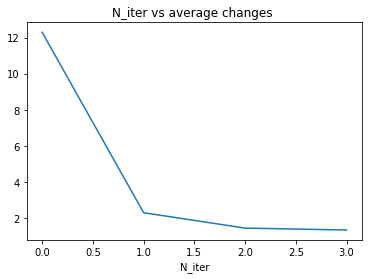

In [3]:
(corpus, tags) = data_dev
K = 5
start = time.time()
(tags_pred, n_changes) = gibbs_predictor(corpus, em_prob, trans_prob, tag2ix, word2ix,ix2tag, K=K)   
runtime = time.time() - start
print("accuracy using gibbs sampling is {}".format(compute_tag_acc(tags_pred, tags)))
print("log prob of gibbs prediction is {}".format(compute_prob_log(corpus, tags_pred, trans_prob, em_prob, word2ix, tag2ix)))
print("runtime for gibbs sampling with K = {} is {}".format(K, runtime))
n_changes = np.array(n_changes)
plt.plot(n_changes.mean(axis = 0))
plt.title("N_iter vs average changes ")
plt.xlabel("N_iter")
plt.show()

### Comment:
With number of iterations growing, the number of changes decrease (but not to zero)

## (d)

```
beta    K       accuracy                log_prob                runtime
1       2       0.77769                 -182094.522             1.66
1       5       0.86306                 -166691.174             6.20
1       10      0.86306                 -166567.8591            13.63
1       50      0.86739                 -166290.0117            73.42
1       100     0.86600                 -166424.6044            148.67
1       500     0.86620                 -166448.0571            751.69
1       1000    0.86656                 -166428.1011            1456.29

```

## (e)

```
beta    K       accuracy                log_prob                runtime
0.5     2       0.63391                 -224944.2369            1.482
0.5     5       0.75964                 -190808.6695            5.585
0.5     10      0.76131                 -189674.8019            12.375
0.5     50      0.76222                 -189671.6142            67.006
0.5     100     0.76465                 -189178.4236            134.737
0.5     500     0.76290                 -189445.7034            680.403
0.5     1000    0.76314                 -189630.1784            1363.908


beta    K       accuracy                log_prob                runtime
2       2       0.79908                 -180006.4834            1.515
2       5       0.87514                 -164752.6507            5.502
2       10      0.87980                 -164395.3786            12.224
2       50      0.88163                 -164146.4202            66.037
2       100     0.88294                 -164019.4404            133.281
2       500     0.88369                 -163981.8099            673.306
2       1000    0.88504                 -163908.7458            1355.406


beta    K       accuracy                log_prob                runtime
5       2       0.80278                 -179218.0286            1.4738
5       5       0.87964                 -164219.2186            5.5659
5       10      0.88159                 -164029.0525            12.2327
5       50      0.88214                 -163926.8255            66.0533
5       100     0.88457                 -163783.9662            133.5858
5       500     0.88473                 -163752.7453            675.1857
5       1000    0.88687                 -163625.3498            1353.0155
```

### Comment:
With bigger $\beta$, we get better accuacry and log_prob for almost all $K$s. 

## (f)

### start from $\beta = 0.1$, then increase it by $0.1$  in each iteration
```
K       accuracy        log_prob        runtime
2       0.01964         -1968835.9106   1.43
5       0.39328         -311310.4384    5.50
10      0.84608         -169426.5513    12.34
50      0.88819         -163498.2672    67.07
100     0.89001         -163392.3143    135.69
500     0.87153         -169634.7072    686.12
1000    0.17518         -434717.2169    1418.21
```

### adjust scheduling by setting a cap for $\beta$
From the experiments above, we can see when $\beta$ gets too large interations, the log-probability becomes very bad, probably because huge $\beta$ makes a very wrong model. In order to remedy it, I decide to add a cap to the value of $\beta$. That is, when $\beta$ hits a certain value (called "cap" below), it ceases to increase. 

Below are the results. The running time are almost the same, so I don't show them below. 

#### cap = 5
```
cap     K       accuracy        log_prob
5       2       0.0191          -1853046.976
5       10      0.3889          -169562.0827
5       50      0.8483          -163439.8790
5       100     0.8886          -163460.3735
5       500     0.8898          -163454.1597
5       1000    0.8906          -163411.5830
```
#### cap = 10
```
cap     K       accuracy        log_prob
10      2       0.0191          -1939250.1183
10      5       0.3951          -311397.0808
10      10      0.8468          -169616.2551
10      50      0.8879          -163487.1764
10      100     0.8908          -163358.5868
10      500     0.8899          -163387.2232
10      1000    0.8905          -163371.0516
```

### Comment:
By setting a cap on $\beta$, we can see both accuracy and log_prob has small increase compared to the one without capping. 

# Gibbs Sampling for Minimum Bayes Risk Inference

## (a)

Let $$L(y) = \sum_{y'} P(Y = y' | X = x) $$ where cost is 1-0 cost.
Then we know $$L(y) = \sum_{y' \neq y} P(Y = y' | X = x) = 1 - P(Y = y | X = x)$$
Therefore $$ \hat{y} = \text{argmin}_{y} L(y) = \text{argmax}_{y} P(Y = y | X = x)$$

## (b)
Easy to see that we can approximate with 

$$ P(Y_t | X = x) \approx \frac{1}{K} \sum_{i = 1}^K 1_{[\tilde{y}_t^{(i)} = y]} $$

So bascially, for a location $t$, we only need to see which tags appear most often among all samples. 

Below I give a more detailed proof:

From equation (5), we have:
\begin{align}
P(Y_t = y | X = x) & = \sum_{y_{-t}} P(Y_t = y, Y_{-t} = y_{-t} | X = x) \\
& \approx \sum_{y_{-t}} \frac{1}{K} \sum_{i = 1}^K 1_{\tilde{y}^{(i)} = y_t}\\
& = \frac{1}{K} \sum_{i = 1}^K \sum_{y_{-t}} 1_{(\tilde{y_t}^{(i)} = y,\tilde{y_{-t}}^{(i)} = y_{-t} )}\\
& = \frac{1}{K} \sum_{i = 1}^K 1_{[\tilde{y}_t^{(i)} = y]}
\end{align}


## (c)

It is implemented in `code/gibbs.py`

### $\beta = 1$
```
beta    K       accuracy          runtime
1       2       0.3967              2
1       5       0.8607              6
1       10      0.8780              13
1       50      0.8893              70
1       100     0.8906              142
1       500     0.8930              717
1       1000    0.8939              1439

```

### Other values of $\beta$
For different $\beta$, the runtime are similar, so I do not show them below. 

### $\beta = 0.5$
```
beta    K       accuracy        
0.5     2       0.3163          
0.5     5       0.8078          
0.5     10      0.8570          
0.5     50      0.8823          
0.5     100     0.8875          
0.5     500     0.8910          
0.5     1000    0.8915          
```


### $\beta = 2$
```
beta    K       accuracy        
2       2       0.40429        
2       5       0.87176         
2       10      0.88159         
2       50      0.88715         
2       100     0.88886         
2       500     0.89109        
2       1000    0.89204         
```

### $\beta = 5$
```
beta    K       accuracy
5       2       0.4079
5       5       0.8750
5       10      0.8815
5       50      0.8843
5       100     0.8858
5       500     0.8880
5       1000    0.8873
```







### $\beta = 10$
```
beta    K       accuracy       
10      2       0.41025         
10      5       0.87296         
10      10      0.88206         
10      50      0.88083         
10      100     0.88377         
10      500     0.88433         
10      1000    0.88628         
```

### Comment:
* MBR with $\beta = 1, K = 1000$ gets the best result I have seen so far. 

* Accuracy increases with $K$.

* $\beta = 1$ gets the best result for large $K$. Increasing $\beta$ beyond 1 decreases the accuracy. 

* This is different from what I observed from using the final sample, which shows the trend that increasing $\beta$ increases accuracy. 
